In [98]:
# Load core libraries
import pandas as pd
import numpy as np
import pickle

In [99]:
# Load datasets
with open('cleaned_data_no_batches/test_data.pkl', 'rb') as file:
    test = pickle.load(file)

with open('cleaned_data_no_batches/train_data.pkl', 'rb') as file:
    train = pickle.load(file)

# Ensure data are dataframes
if not isinstance(test, pd.DataFrame):
    raise ValueError("Loaded data is not a pandas DataFrame.")

if not isinstance(train, pd.DataFrame):
    raise ValueError("Loaded data is not a pandas DataFrame.")


In [100]:
#! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.12"

In [101]:
#!pip install tsfm

In [102]:
print(train)

       unit_number  time_cycles  RUL  Bleed Enthalpy  Bypass Ratio  \
0                1            1  191      392.224572      8.417222   
1                1            2  190      392.230768      8.417310   
2                1            3  189      392.236073      8.417390   
3                1            4  188      392.240902      8.417468   
4                1            5  187      392.245241      8.417551   
...            ...          ...  ...             ...           ...   
20626          100          196    4      394.690106      8.478995   
20627          100          197    3      394.692692      8.479073   
20628          100          198    2      394.695409      8.479139   
20629          100          199    1      394.697911      8.479182   
20630          100          200    0      394.699796      8.479210   

       Coolant Bleed, HPT  Coolant Bleed, LPT  Corr. Speed, Fan  Speed, core  \
0               38.937396           23.363193       2388.056196  9056.295210   

In [103]:
# Function to expand & interpolate existing points to create new, granular points
def expand_and_interpolate(df):
    # Create an empty DataFrame to store results
    expanded_df = pd.DataFrame()

    # Process each unit number separately
    for unit in df['unit_number'].unique():
        # Filter for the current unit number
        unit_df = df[df['unit_number'] == unit].copy()

        # Expand the time_cycles by creating a range with 4 times the number of cycles
        new_index = np.arange(unit_df['time_cycles'].min(), unit_df['time_cycles'].max() + 1, 0.25)
        unit_df = unit_df.set_index('time_cycles').reindex(new_index)

        # Interpolate all columns linearly
        unit_df = unit_df.interpolate(method='linear')

        # Reset the index and assign the unit number back
        unit_df['unit_number'] = unit
        unit_df = unit_df.reset_index().rename(columns={'index': 'time_cycles'})

        # Append to the result DataFrame
        expanded_df = pd.concat([expanded_df, unit_df], ignore_index=True)

    return expanded_df

# Usage example
#train = expand_and_interpolate(train)
print(train)

       unit_number  time_cycles  RUL  Bleed Enthalpy  Bypass Ratio  \
0                1            1  191      392.224572      8.417222   
1                1            2  190      392.230768      8.417310   
2                1            3  189      392.236073      8.417390   
3                1            4  188      392.240902      8.417468   
4                1            5  187      392.245241      8.417551   
...            ...          ...  ...             ...           ...   
20626          100          196    4      394.690106      8.478995   
20627          100          197    3      394.692692      8.479073   
20628          100          198    2      394.695409      8.479139   
20629          100          199    1      394.697911      8.479182   
20630          100          200    0      394.699796      8.479210   

       Coolant Bleed, HPT  Coolant Bleed, LPT  Corr. Speed, Fan  Speed, core  \
0               38.937396           23.363193       2388.056196  9056.295210   

In [104]:
from tsfm_public import TimeSeriesPreprocessor
from sklearn.preprocessing import StandardScaler

# Define column specifiers
column_specifiers = {
    "timestamp_column": "RUL",  # Use your actual timestamp column name
    "target_columns": ["Bleed Enthalpy"],          # Use your actual target column name(s)
    "observable_columns": ["Coolant Bleed, LPT", "Coolant Bleed, HPT"]  # Use your actual feature column names
}

# Initialize the preprocessor with necessary parameters
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=512,  # Adjust based on your data
    prediction_length=96,  # Adjust based on your forecasting horizon
    scaling=True,
    encode_categorical=False,
    scaler_type="standard"
)

# Scaling the target and observable columns manually
scaler = StandardScaler()
train[column_specifiers["target_columns"]] = scaler.fit_transform(train[column_specifiers["target_columns"]])
train[column_specifiers["observable_columns"]] = scaler.fit_transform(train[column_specifiers["observable_columns"]])

# Define the expected sequence length for the model
expected_sequence_length = 512

# Function to pad or truncate each sequence
def pad_or_truncate(sequence, length):
    if len(sequence) > length:
        # Truncate the sequence
        return sequence[:length]
    elif len(sequence) < length:
        # Pad the sequence with zeros
        return np.pad(sequence, (0, length - len(sequence)), 'constant')
    else:
        return sequence

# Apply padding/truncation to each row in your input columns
inputs = np.array([
    pad_or_truncate(seq, expected_sequence_length)
    for seq in train[column_specifiers["observable_columns"]].values
])

# Check the shape of inputs and reshape if needed
inputs = np.expand_dims(inputs, axis=-1)  # Add an extra dimension for compatibility

# Convert to PyTorch tensor for model input
inputs_tensor = torch.tensor(inputs).float()

# Ensure targets are in the right shape as well (no need for sequence length adjustment)
targets_tensor = torch.tensor(train[column_specifiers["target_columns"]].values).float()

# Prepare the processed data dictionary for model input
processed_data = {
    "inputs": inputs_tensor,
    "targets": targets_tensor
}

# Check the final shape of inputs_tensor for debugging
print("Shape of inputs_tensor:", inputs_tensor.shape)
print("Shape of targets_tensor:", targets_tensor.shape)


Shape of inputs_tensor: torch.Size([20631, 512, 1])
Shape of targets_tensor: torch.Size([20631, 1])


In [105]:
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction

# Load the pre-trained model
model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-v1",
    revision="main"  # Use the appropriate branch for your context and prediction lengths
)


In [106]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert processed data to tensors
inputs = torch.tensor(processed_data['inputs']).float()
targets = torch.tensor(processed_data['targets']).float()

# Create a dataset and dataloader
dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=512, shuffle=False)


<ipython-input-106-792194f99f62>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(processed_data['inputs']).float()
<ipython-input-106-792194f99f62>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(processed_data['targets']).float()


In [112]:
# Assume model is loaded and data is preprocessed as per previous steps
model.eval()  # Set the model to evaluation mode

# Perform inference and access the tensor from the model output
predictions = []
with torch.no_grad():  # Disable gradient calculations for inference
    for input_batch in processed_data['inputs']:
        # Ensure input_batch has the correct dimensions for model input
        output = model(input_batch.unsqueeze(0))  # Add batch dimension if needed
        # Access the primary output tensor (adjust as per actual attribute, e.g., output.predictions or output.logits)
        predictions.append(output.prediction_outputs)  # Replace with actual attribute name

# Concatenate the predictions into a single tensor or array
predictions = torch.cat(predictions, dim=0).numpy()


In [113]:
predictions

array([[[ 0.00120248],
        [ 0.00076487],
        [ 0.00097133],
        ...,
        [ 0.00676783],
        [ 0.00771873],
        [ 0.00771203]],

       [[ 0.00119851],
        [ 0.00076124],
        [ 0.00096731],
        ...,
        [ 0.0067372 ],
        [ 0.00768329],
        [ 0.00767704]],

       [[ 0.001195  ],
        [ 0.00075831],
        [ 0.00096394],
        ...,
        [ 0.0067121 ],
        [ 0.00765436],
        [ 0.0076484 ]],

       ...,

       [[-0.00401645],
        [-0.00112302],
        [ 0.00183608],
        ...,
        [-0.04747966],
        [-0.04413081],
        [-0.04548259]],

       [[-0.004021  ],
        [-0.00113322],
        [ 0.00183104],
        ...,
        [-0.04747619],
        [-0.04412522],
        [-0.04547542]],

       [[-0.00402419],
        [-0.001142  ],
        [ 0.00182618],
        ...,
        [-0.04746313],
        [-0.04411097],
        [-0.04545948]]], dtype=float32)

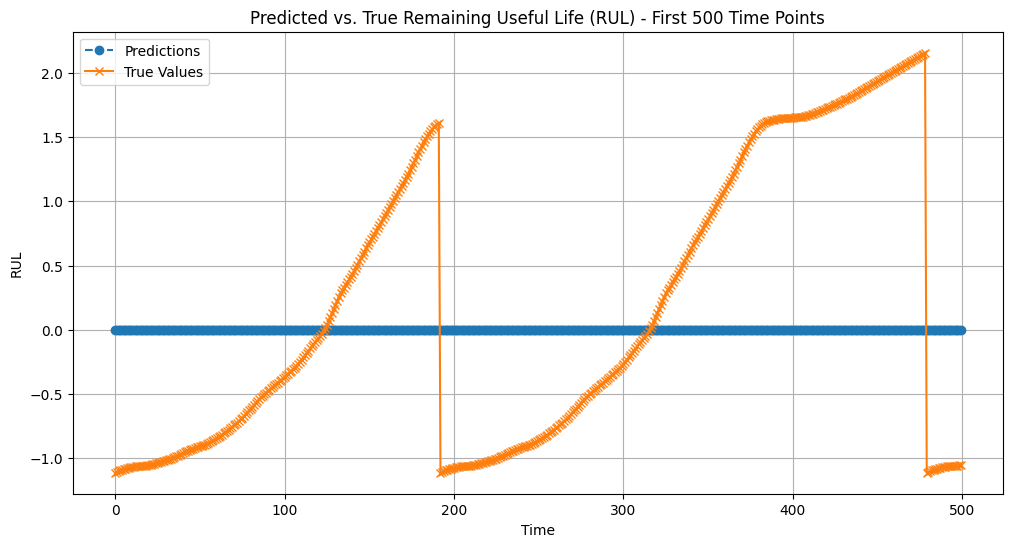

In [119]:
import matplotlib.pyplot as plt

# Convert the targets tensor to a numpy array if not already
targets = targets_tensor.numpy()

# Select only the first 500 time points
time_indices = range(500)
predictions_subset = predictions[:500]
targets_subset = targets[:500]

# Plotting the true values and predictions for the first 500 time points
plt.figure(figsize=(12, 6))
plt.plot(time_indices, predictions_subset[:,1], label='Predictions', linestyle='--', marker='o')
plt.plot(time_indices, targets_subset, label='True Values', linestyle='-', marker='x')
plt.xlabel('Time')
plt.ylabel('RUL')
plt.title('Predicted vs. True Remaining Useful Life (RUL) - First 500 Time Points')
plt.legend()
plt.grid(True)
plt.show()
